# Multi-Objective Optimal Power Flow (OPF) for Radial Distribution Grid

In [1]:
__author__ = "Andy Putratama"
__website__ = "andyptr.github.io"

# Table of contents
1. [Introduction](#Introduction)
    1. [Test Case](#Use_case)
    1. [Preliminary test](#Preliminary)
    1. [Objective](#Objective)    
2. [Proposed Voltage Control](#Proposed)
    1. [Description](#OPF_desc)
    2. [Simulation](#Simulation)
    3. [Accuracy Test](#Accuracy)
    4. [Comparing with DC OPF](#DC_OPF)
3. [Sensitivity Analysis](#Sensitivity)
4. [Conclusion](#Conclusion)

### Required modules/Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import algo # Developed package for this project 

# 1) Introduction <a name="Introduction"></a>

## 1. A) Test Case <a name="Use_case"></a>

In this study, we use the IEEE 33-bus [1] feeder for the test case. 10 additional 1MW PVs are implented at bus [2, 5, 7, 9, 12, 16, 21, 24, 26, 30], as shown in the figure below.


<sup>
Ref: 
[1] Khanh, B.Q. and Hojo, M. (2019), Optimally selecting the location of a multiple of D-statcoms for the improvement of SARFIX due to faults in the IEEE 33-bus distribution system. IEEJ Trans Elec Electron Eng, 14: 1172-1180. https://doi.org/10.1002/tee.22915
</sup>


<br>
<center><img src="data/images/01/33bus.png" width="700"/></center>
<br>

## 1. B) Preliminary test <a name="Preliminary"></a>


In the preliminary test, we try to observe the voltage profile at one particular time step. The PVs and loads are configured as follow:
* The loads follow the original IEEE 33-bus load data [1].
* The PVs inject full active power of 1MW. The PVs do not inject/absorb reactive power.

To obeserve the voltage profile, we perform a load flow simulation using a conventional solver called Panda Power [2].


<sup>Ref:
[2] L. Thurner, A. Scheidler, F. Schäfer et al, pandapower - an Open Source Python Tool for Convenient Modeling, Analysis and Optimization of Electric Power Systems, in IEEE Transactions on Power Systems, vol. 33, no. 6, pp. 6510-6521, Nov. 2018.
</sup>

To start the test, firstly we need to load the grid data

In [3]:
data_dir = "data/33bus_PV.xlsx"

Create the network data for Panda Power

In [4]:
net = algo.load_data.rt_network(data_dir)

Run the preliminary **load flow** with Panda Power

In [6]:
net, time_preliminary = algo.solve.load_flow(net)

Extract the voltage results

In [7]:
voltage_preliminary = net.res_bus["vm_pu"].copy()

Plot the preliminary voltage profile

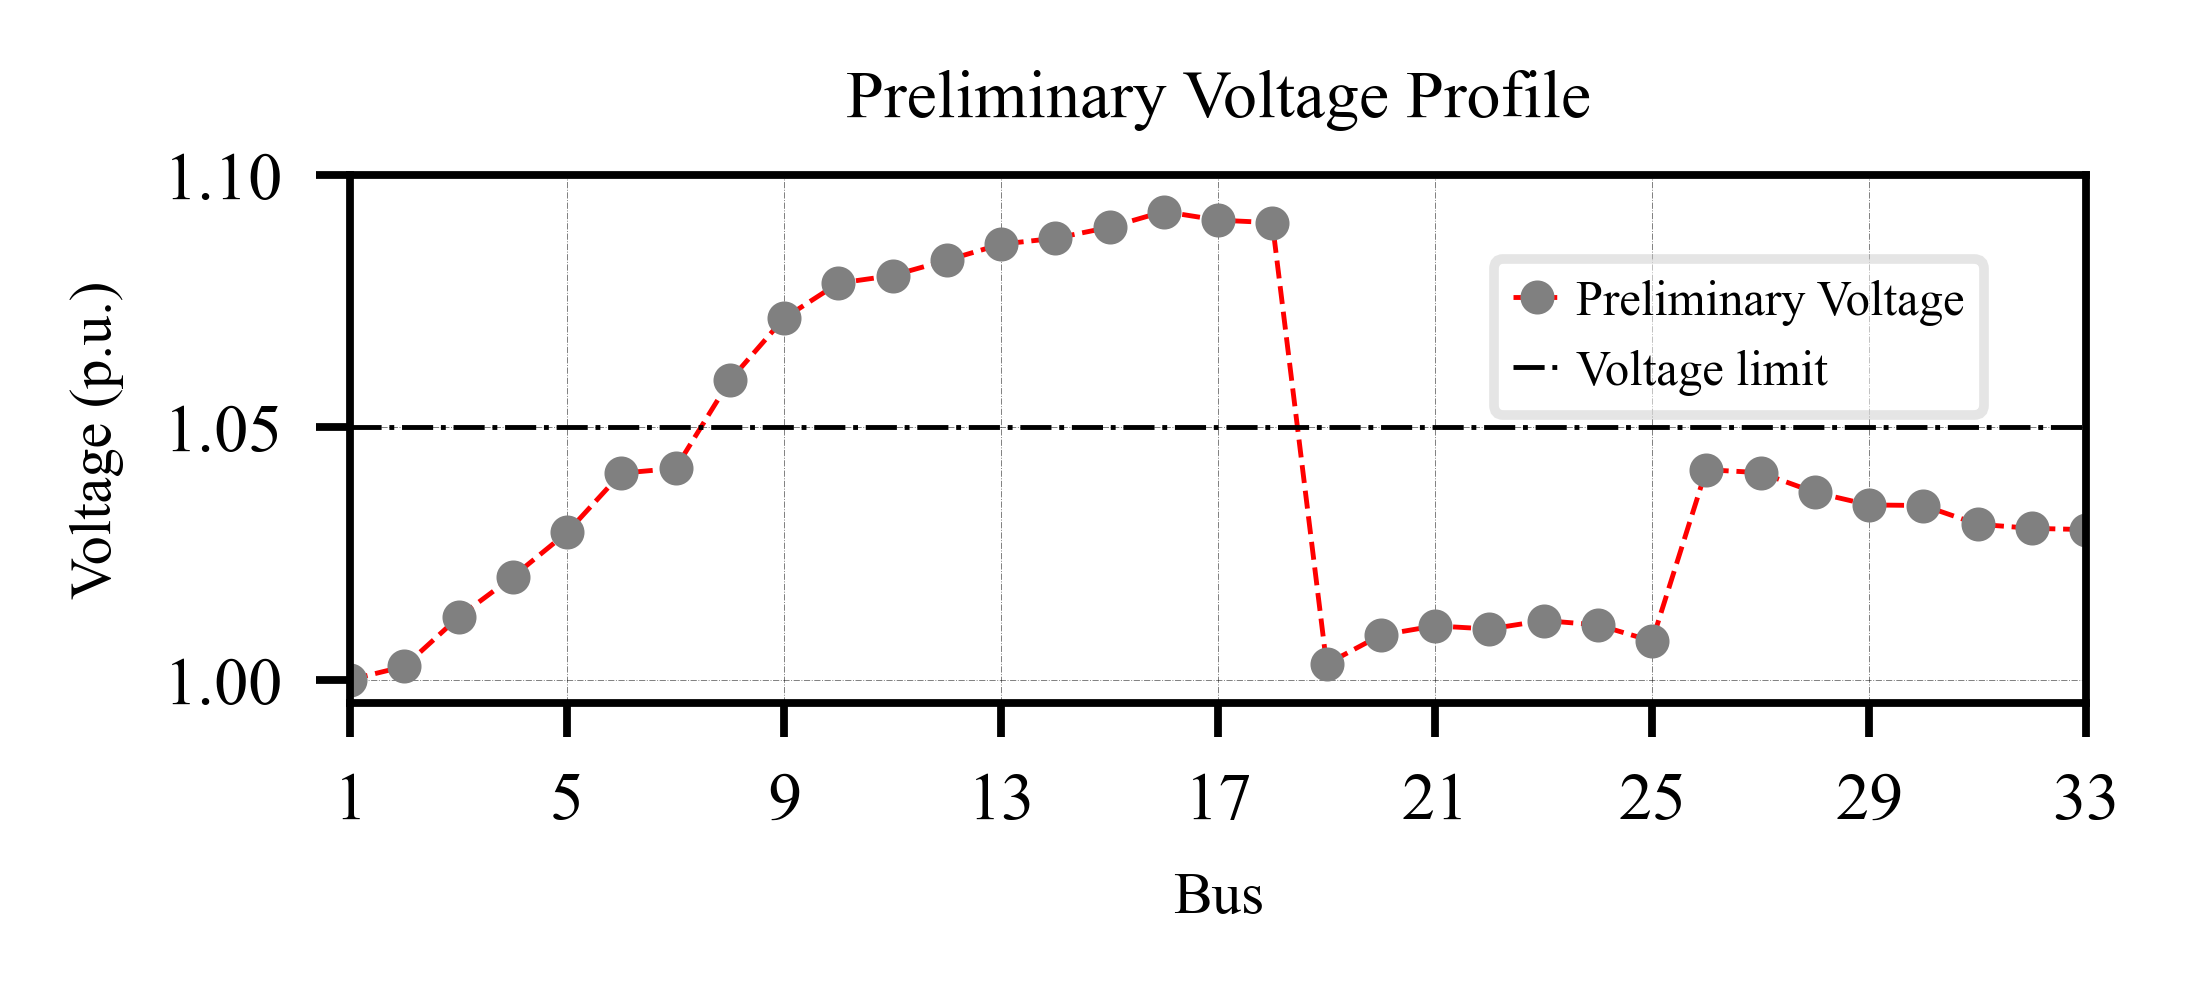

In [8]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700)
csfont = {'fontname': 'Times New Roman'}

# Plot preliminary voltage
ax.plot(voltage_preliminary ,linestyle = "--",linewidth = .5, marker = ".", markersize = 5, 
        alpha=1, mec='gray', mfc = "gray", color ="red", label = "Preliminary Voltage")
# Plot voltage limit
ax.plot(voltage_preliminary.index, [1.05 for _ in voltage_preliminary.index],
        linestyle = "-.",linewidth = .5, alpha=1, color ="k", label = "Voltage limit")

# Axis setting
ax.set_xticks([idx for idx in voltage_preliminary.index if idx%4 == 0])
ax.set_xticklabels(np.array([idx for idx in voltage_preliminary.index if idx%4 == 0])+1)
ax.set_yticks([1, 1.05, 1.1])
ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('Voltage (p.u.)', fontsize=6, **csfont,)
ax.set_xlabel('Bus', fontsize=6, **csfont)
ax.set_title('Preliminary Voltage Profile', fontsize=7, **csfont)


ax.autoscale(enable=True, axis='x', tight=True)

leg = ax.legend(fancybox=True, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.8, 0.5), 
                ncol = 1, prop={'family': 'Times New Roman', 'size': 5},
               handletextpad=0.3, handlelength=1, columnspacing=0.7,)

As we can see in the figure above, the voltage at certain bus exceed the upper voltage limit (1.05 p.u.). This highlights that a high penetration of PV may lead to **overvoltage** in the distribution grid.


In order to mitigate the voltage violation, we have to curtail the PVs production. However, the PVs have to be **optimally curtailed** in order to fully maximize the benefit of local energy production.

## 1. C) Study Objective <a name="Objective"></a>

Therefore, the objectives of this study are:
1. Propose a voltage control solution to maintain grid voltage by curtailing PV production
1. Compare the proposed controller with other voltage control solution
2. Perform sensitivity analysis of the proposed controller

# 2) Proposed Voltage Control / OPF formulation <a name="Proposed"></a>

## 2. A) Short Description <a name="OPF_desc"></a>

The proposed voltage control is formulized as an optimal power flow (OPF) problem with second-order conic programming (SOCP). The detailed explanation of the proposed controller can be found on my publication [3].


<sup>Ref: [3] M. A. Putratama, R. Rigo-Mariani, V. Debusschere and Y. Besanger, "Parameter Tuning for LV Centralized and Distributed Voltage Control with High PV Production," 2021 IEEE Madrid PowerTech, 2021, pp. 1-6, doi: 10.1109/PowerTech46648.2021.9494802.
</sup>

### Brief formulation

Briefly, the voltage control aims to minimized the **grid losses** and total **PV curtailments**, as follow:

$$\large{\min C_{loss} \underbrace{\sum_{(i,j) \in E} \ell_{ij}r_{ij}}_{\text{losses}} + C_{pv} \underbrace{\sum_{b \in B} P^{pv}_b - P^{pv*}_b}_\text{PV curtailments}}$$

Subject to **Grid constraints**, **PV constraints**, **voltage constraints**, and **SOCP/Convex relaxation** as follow:

$$\large{\ell_{ij} \geq \frac{P_{ij}^2+Q_{ij}^2}{\nu_i}}$$

The relaxation relaxed the original **equality** branch current equation into an **inequality** relation.

Additional controller parameters **C<sub>loss</sub>** and **C<sub>pv</sub>** are introduced to give additional weights between to objective functions.

### Why Convex relaxation?

Because a convex problem is easy to solve and optimality of the soluiton can be guaranteed.

### Simulation Process

The simulation process is illustrated in the figure below.
1. The controller uses the deterministic PV and load data as the input.
2. The controller **computes** the optimal PV setpoint for the given load and PV profile.
3. The controller **sends** the optimal PV setpoints to the "real grid"/Panda Power.
4. We perform a load flow calculation with Panda Power, to simulate the "real grid", thus voltage can be observed.

<br>
<center><img src="data/images/01/process.png" width="600"/></center>
<br>

## 2. B) Simulation <a name="Simulation"></a>

Firstly, we configure the controller by setting the following parameters.

In [9]:
param = {"S_base": 20, # Base MVA
         "V_base" : 12.66, # Base voltage (based on IEEE 33 bus)
         "V_min" : 0.95, # Min operating voltage
         "V_max" : 1.05, # Max operating voltage
         "c_pv" : .5, # Cpv in the objective function
        "c_loss" : 1} # Closs in the objective function

Generate the bus and branch data for the controller.

In [10]:
bus_data, branch_data = algo.load_data.opf_socp(data_dir, param)

**Execute** the OPF/Controller:

In [11]:
bus_data, branch_data, time_opf = algo.solve.opf_socp(bus_data, branch_data, param)


As illustrated in the previous figure, the output of the controller is the **optimal PV setpoints**. Alternatively, these setpoints can also be visualized as required PV curtailments:

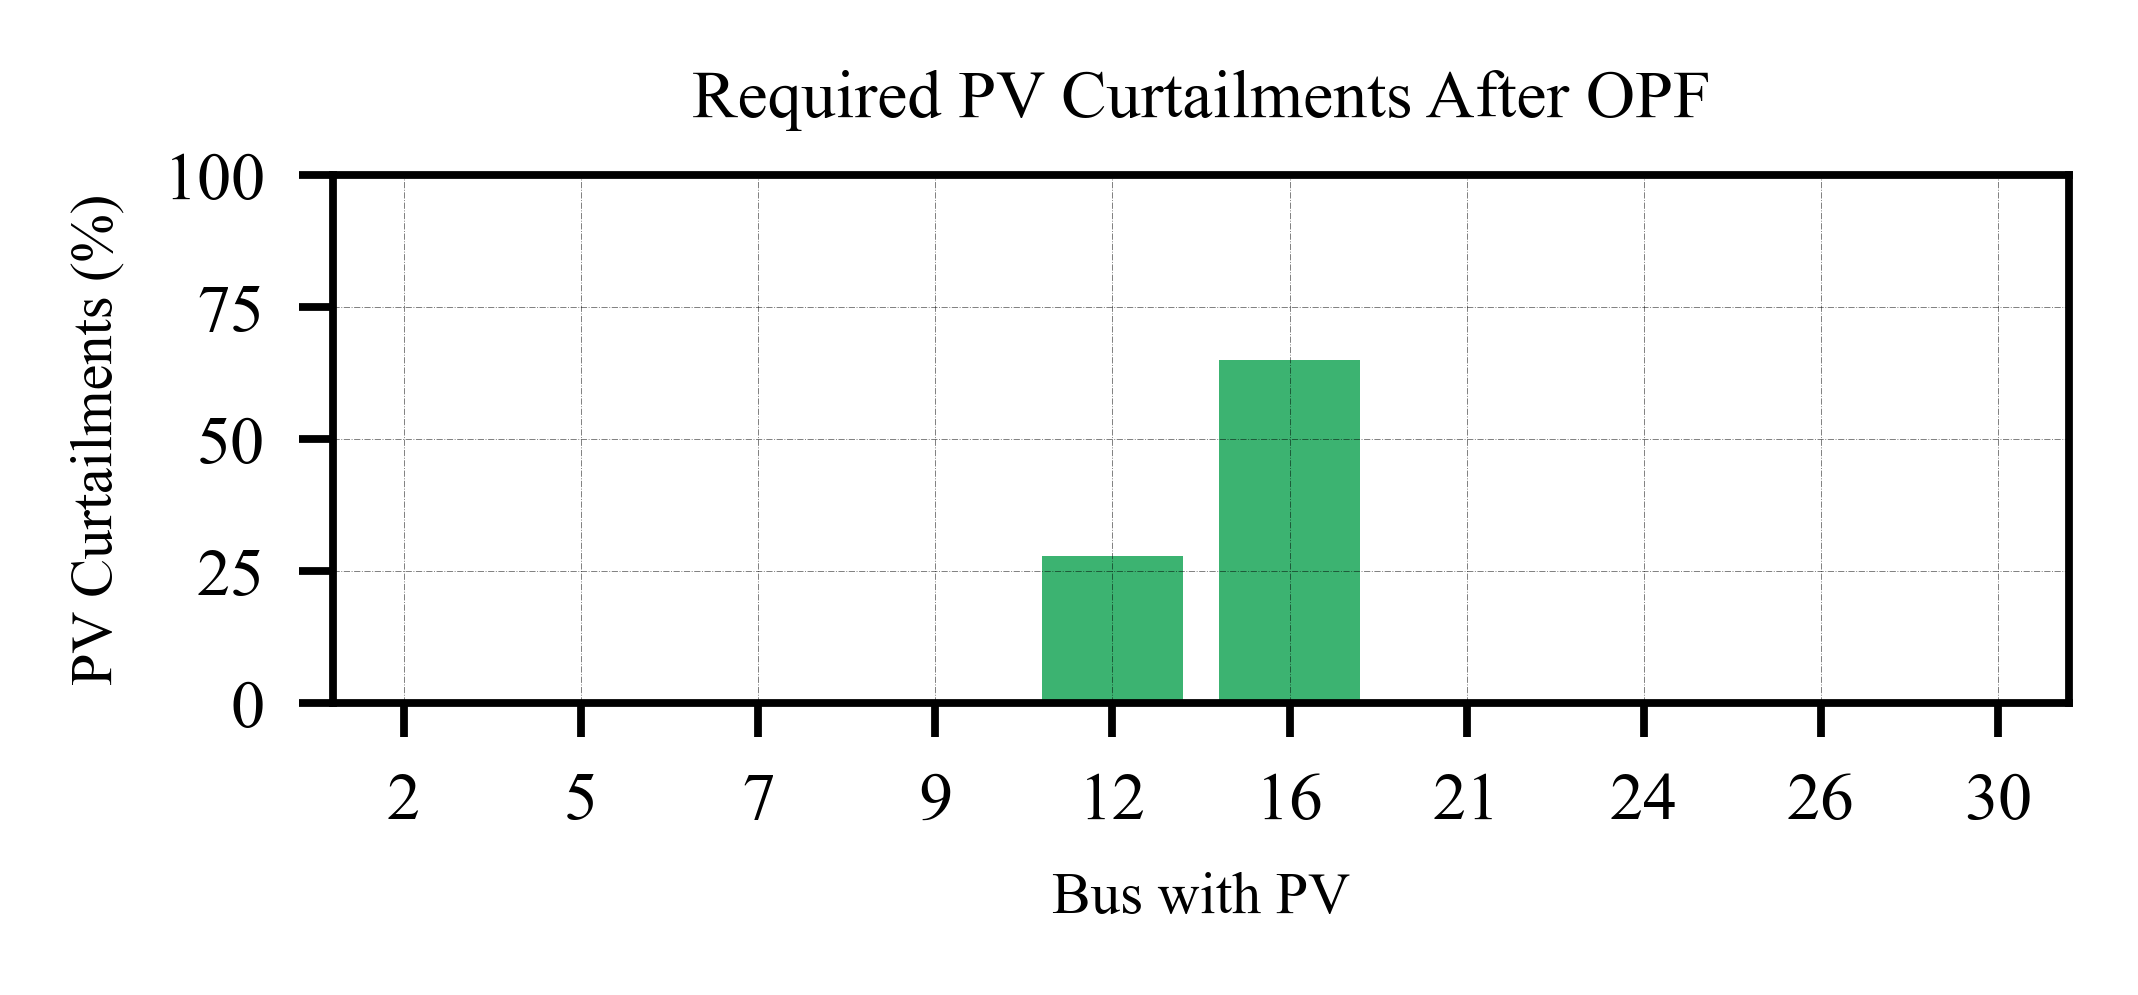

In [12]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700)
csfont = {'fontname': 'Times New Roman'}

bus_with_pv = bus_data[bus_data["S_PV"] > 0].index

# Plot PV Curtailments
ax.bar([pv for pv in range(len(bus_data.index[bus_with_pv]))], bus_data["curt"].values[bus_with_pv],
      color = "mediumseagreen")    

ax.set_xticks([pv for pv in range(len(bus_data.index[bus_with_pv]))])
ax.set_xticklabels(bus_with_pv + 1)

ax.set_yticks(np.arange(0,101, 25))

ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('PV Curtailments (%)', fontsize=6, **csfont,)
ax.set_xlabel('Bus with PV', fontsize=6, **csfont)
ax.set_title('Required PV Curtailments After OPF', fontsize=7, **csfont)


ax.autoscale(enable=True, axis='x', tight=True)


The PVs at bus 12 and 16 have to be curtailed in order to maintain the grid voltage within the limit. Interestingly, other PVs are not curtailed. This is because bus 12 and bus 16 located in the **weak part** of the grid. 

This situation leads to **unfair** environment, since The PV owners at bus 12 and 16 will incur economic loss and they will sell fewer energy compared to their neighbors.

Now, let's inject the optimal PV setpoints to the actual grid, by performing load flow with Panda Power. Firstly, we update the network data:

In [13]:
net = algo.load_data.rt_network_update(net, bus_data, param)

Run the load flow

In [15]:
net, time_lf_opt = algo.solve.load_flow(net)

Extract the voltage results

In [16]:
voltage_optimal = net.res_bus["vm_pu"].copy()

Let's compare the optimized voltage and the preliminary voltage

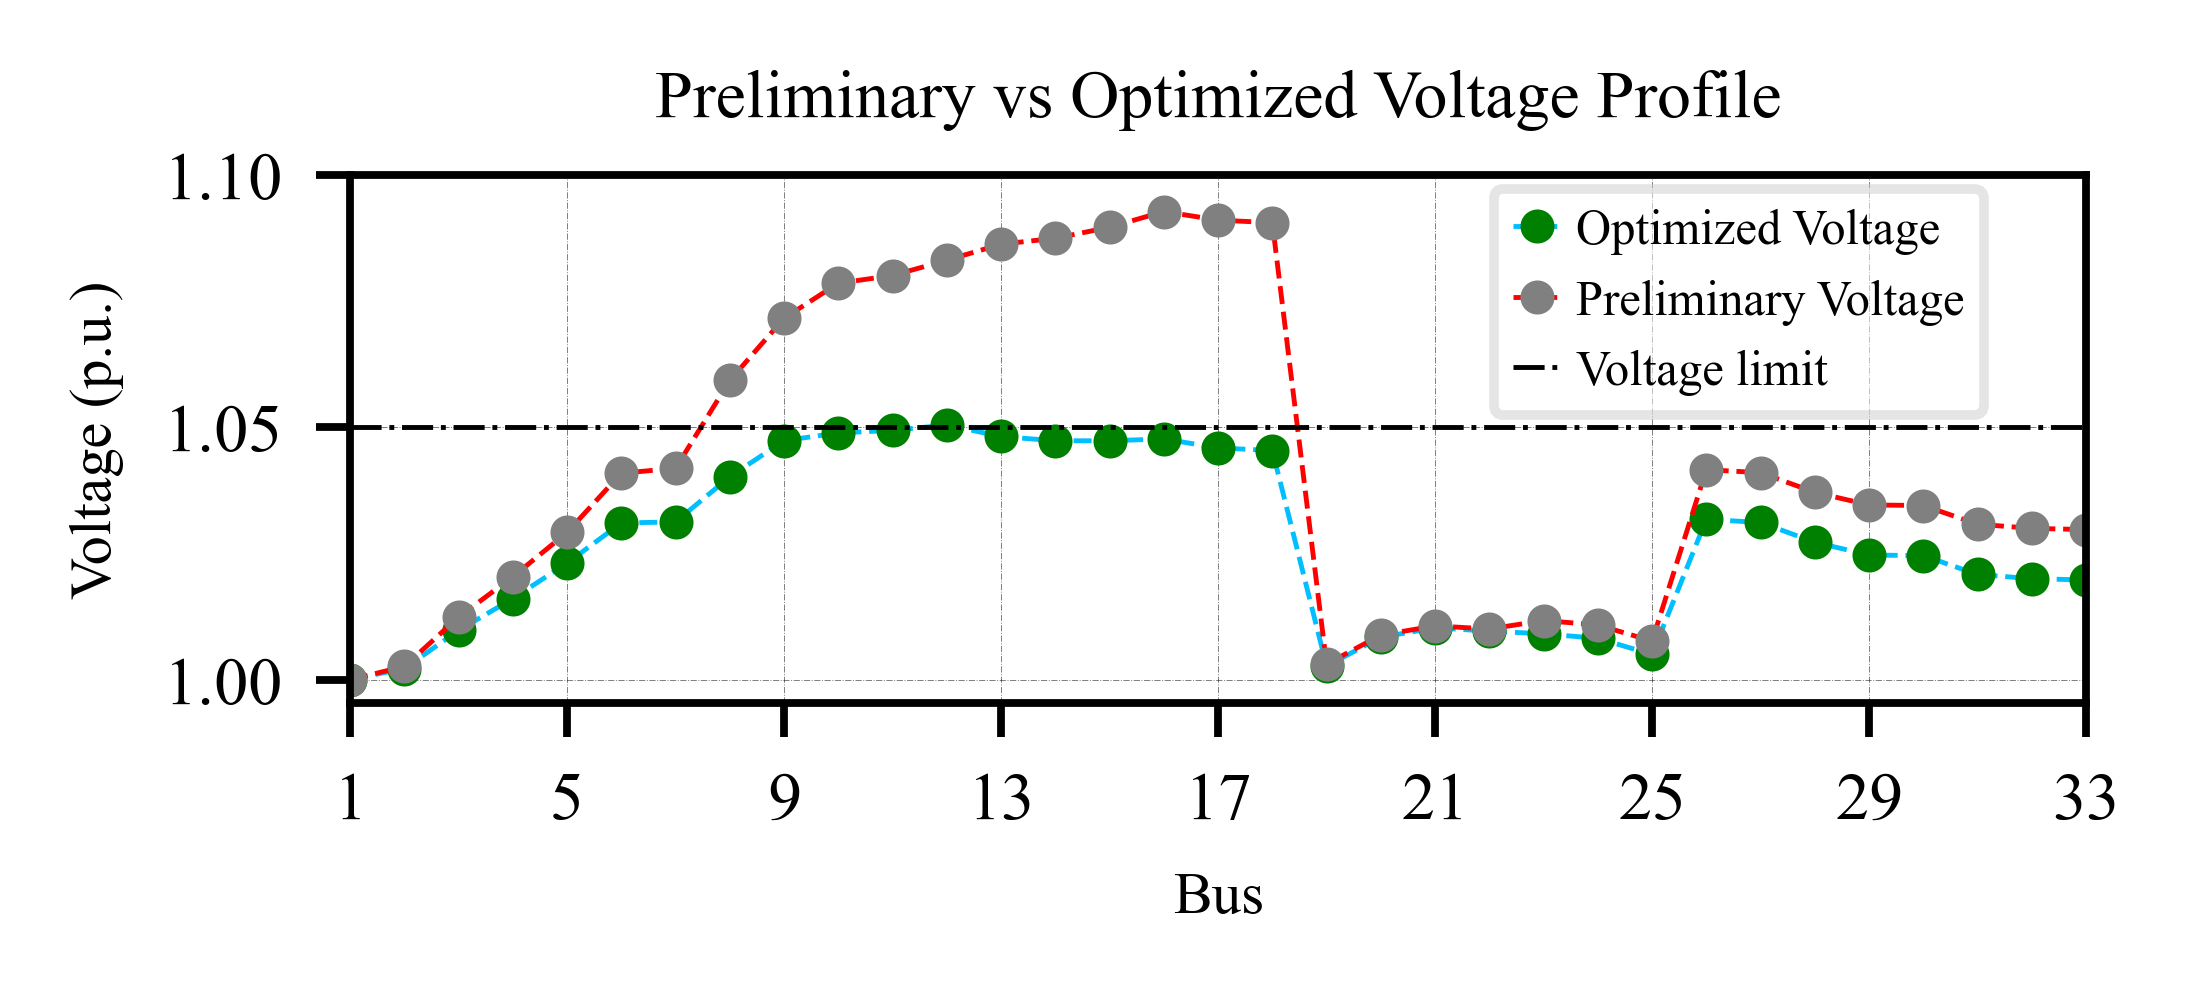

In [17]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700)
csfont = {'fontname': 'Times New Roman'}

# Optimized voltage
ax.plot(voltage_optimal ,linestyle = "--",linewidth = .5, marker = ".", markersize = 5, 
        alpha=1, mec='green', mfc = "green", color ="deepskyblue", label = "Optimized Voltage")

# Preliminary voltage
ax.plot(voltage_preliminary ,linestyle = "--",linewidth = .5, marker = ".", markersize = 5, 
        alpha=1, mec='gray', mfc = "gray", color ="red", label = "Preliminary Voltage")

# Voltage limit
ax.plot(voltage_preliminary.index, [1.05 for _ in voltage_preliminary.index],
        linestyle = "-.",linewidth = .5, 
        alpha=1, color ="k", label = "Voltage limit")
    
ax.set_xticks([idx for idx in voltage_preliminary.index if idx%4 == 0])
ax.set_xticklabels(np.array([idx for idx in voltage_preliminary.index if idx%4 == 0])+1)

ax.set_yticks([1, 1.05, 1.1])

ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('Voltage (p.u.)', fontsize=6, **csfont,)
ax.set_xlabel('Bus', fontsize=6, **csfont)
ax.set_title('Preliminary vs Optimized Voltage Profile', fontsize=7, **csfont)


ax.autoscale(enable=True, axis='x', tight=True)

leg = ax.legend(fancybox=True, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.8, 0.5), 
                ncol = 1, prop={'family': 'Times New Roman', 'size': 5},
               handletextpad=0.3, handlelength=1, columnspacing=0.7,)

The optimized voltage can maintain the voltage just below the limit line!

## 2. C) Accuracy of the Proposed Controller <a name="Accuracy"></a>

The proposed controller is a model-based controller. Internally, the controller mimic/simulate the real grid in order to compute the optimal PV setpoints and it also estimates the resulted voltage profile for the computed setpoints.

Now, we try to compare the voltage estimated by the controller with the actual grid voltage to observe the accuracy of the controller.

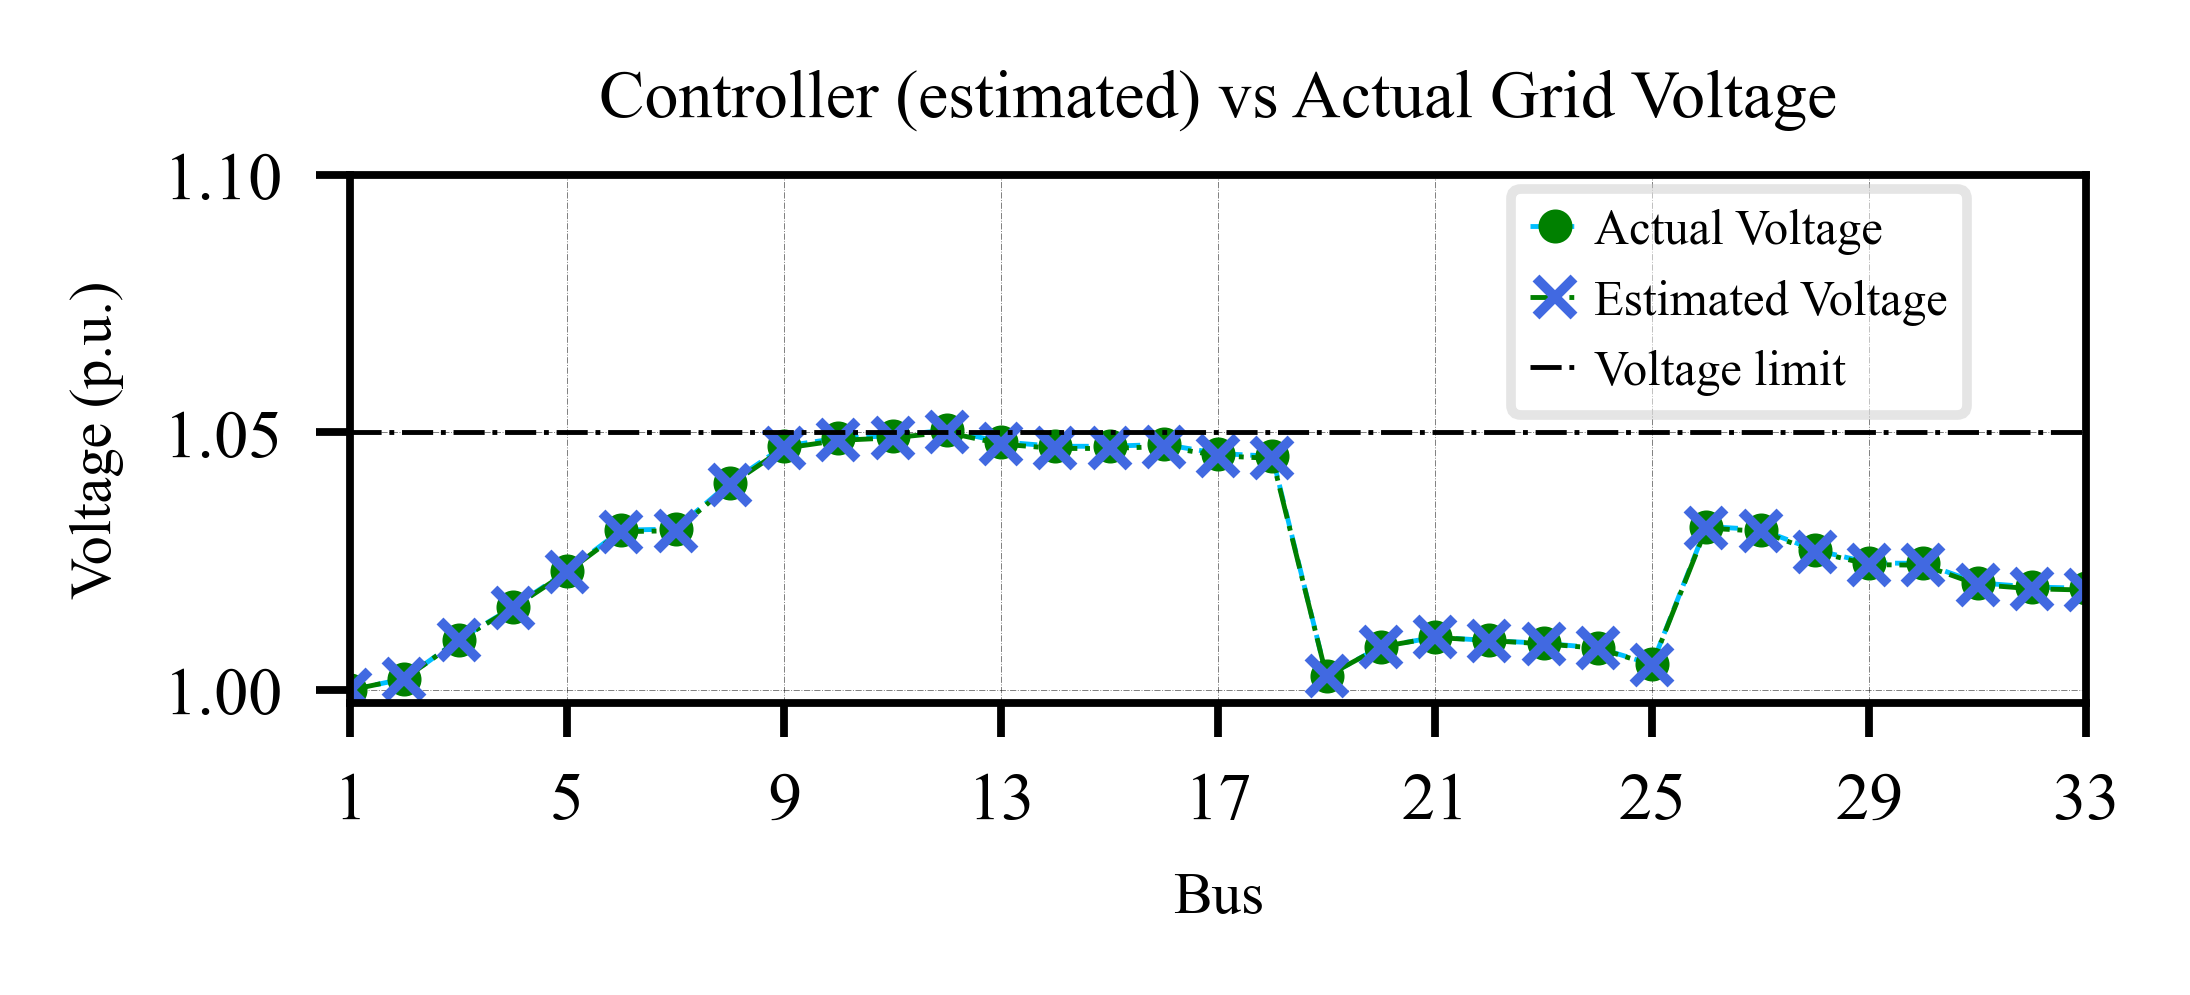

In [18]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700)
csfont = {'fontname': 'Times New Roman'}

# Actual grid voltage
ax.plot(voltage_optimal ,linestyle = "--",linewidth = .5, marker = ".", markersize = 5, 
        alpha=1, mec='green', mfc = "green", color ="deepskyblue", label = "Actual Voltage")
# Estimated voltage from the controller
ax.plot(bus_data["voltage"] ,linestyle = "-.",linewidth = .5, marker = "x", markersize = 4, 
        alpha=1, mec='royalblue', mfc = "royalblue", color ="green", label = "Estimated Voltage")
# Voltage limit
ax.plot(voltage_optimal.index, [1.05 for _ in voltage_optimal.index],
        linestyle = "-.",linewidth = .5, 
        alpha=1, color ="k", label = "Voltage limit")

    
ax.set_xticks([idx for idx in voltage_optimal.index if idx%4 == 0])
ax.set_xticklabels(np.array([idx for idx in voltage_optimal.index if idx%4 == 0])+1)

ax.set_yticks([1, 1.05, 1.1])

ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('Voltage (p.u.)', fontsize=6, **csfont,)
ax.set_xlabel('Bus', fontsize=6, **csfont)
ax.set_title('Controller (estimated) vs Actual Grid Voltage', fontsize=7, **csfont)


ax.autoscale(enable=True, axis='x', tight=True)

leg = ax.legend(fancybox=True, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.8, 0.5), 
                ncol = 1, prop={'family': 'Times New Roman', 'size': 5},
               handletextpad=0.3, handlelength=1, columnspacing=0.7,)

We can see that the estimated voltage perfectly match the actual grid voltage. This highlights the high accuracy of the controller and the convex relaxation.

Due to its accuracy, the proposed controller then can also be used as a load flow solver by performing slight modifications:
1. Take out the 2nd objective (PV curtailment part)
2. Take out the voltage operating limit
3. Set the PV as parameters (not variables)

Performing a load flow with the proposed controller leads to faster computational time than the conventional load flow solver:

In [19]:
f"Proposed controller = {time_opf} s, Panda Power = {time_preliminary} s"

'Proposed controller = 0.4995489579999912 s, Panda Power = 1.3651242920000044 s'

## 2. D) Comparison with DC OPF  <a name="DC_OPF"></a>

To further compare, let's compare the proposed controller with DC OPF, which is widely used method to relax an OPF problem.

Now let's run DC OPF:

In [20]:
bus_data_dc, branch_data_dc, time_dc = algo.solve.opf_dc(bus_data.copy(), branch_data.copy(), param)

Update the network with the setpoints obtained from the DC OPF

In [21]:
net = algo.load_data.rt_network_update(net, bus_data_dc, param)

Run the load flow

In [23]:
net, time_lf_dc = algo.solve.load_flow(net)

Extract the voltage results

In [24]:
voltage_dc = net.res_bus["vm_pu"].copy()

To compare the performance, we can first observe the estimated voltage profile from DC OPF with the actual grid voltage

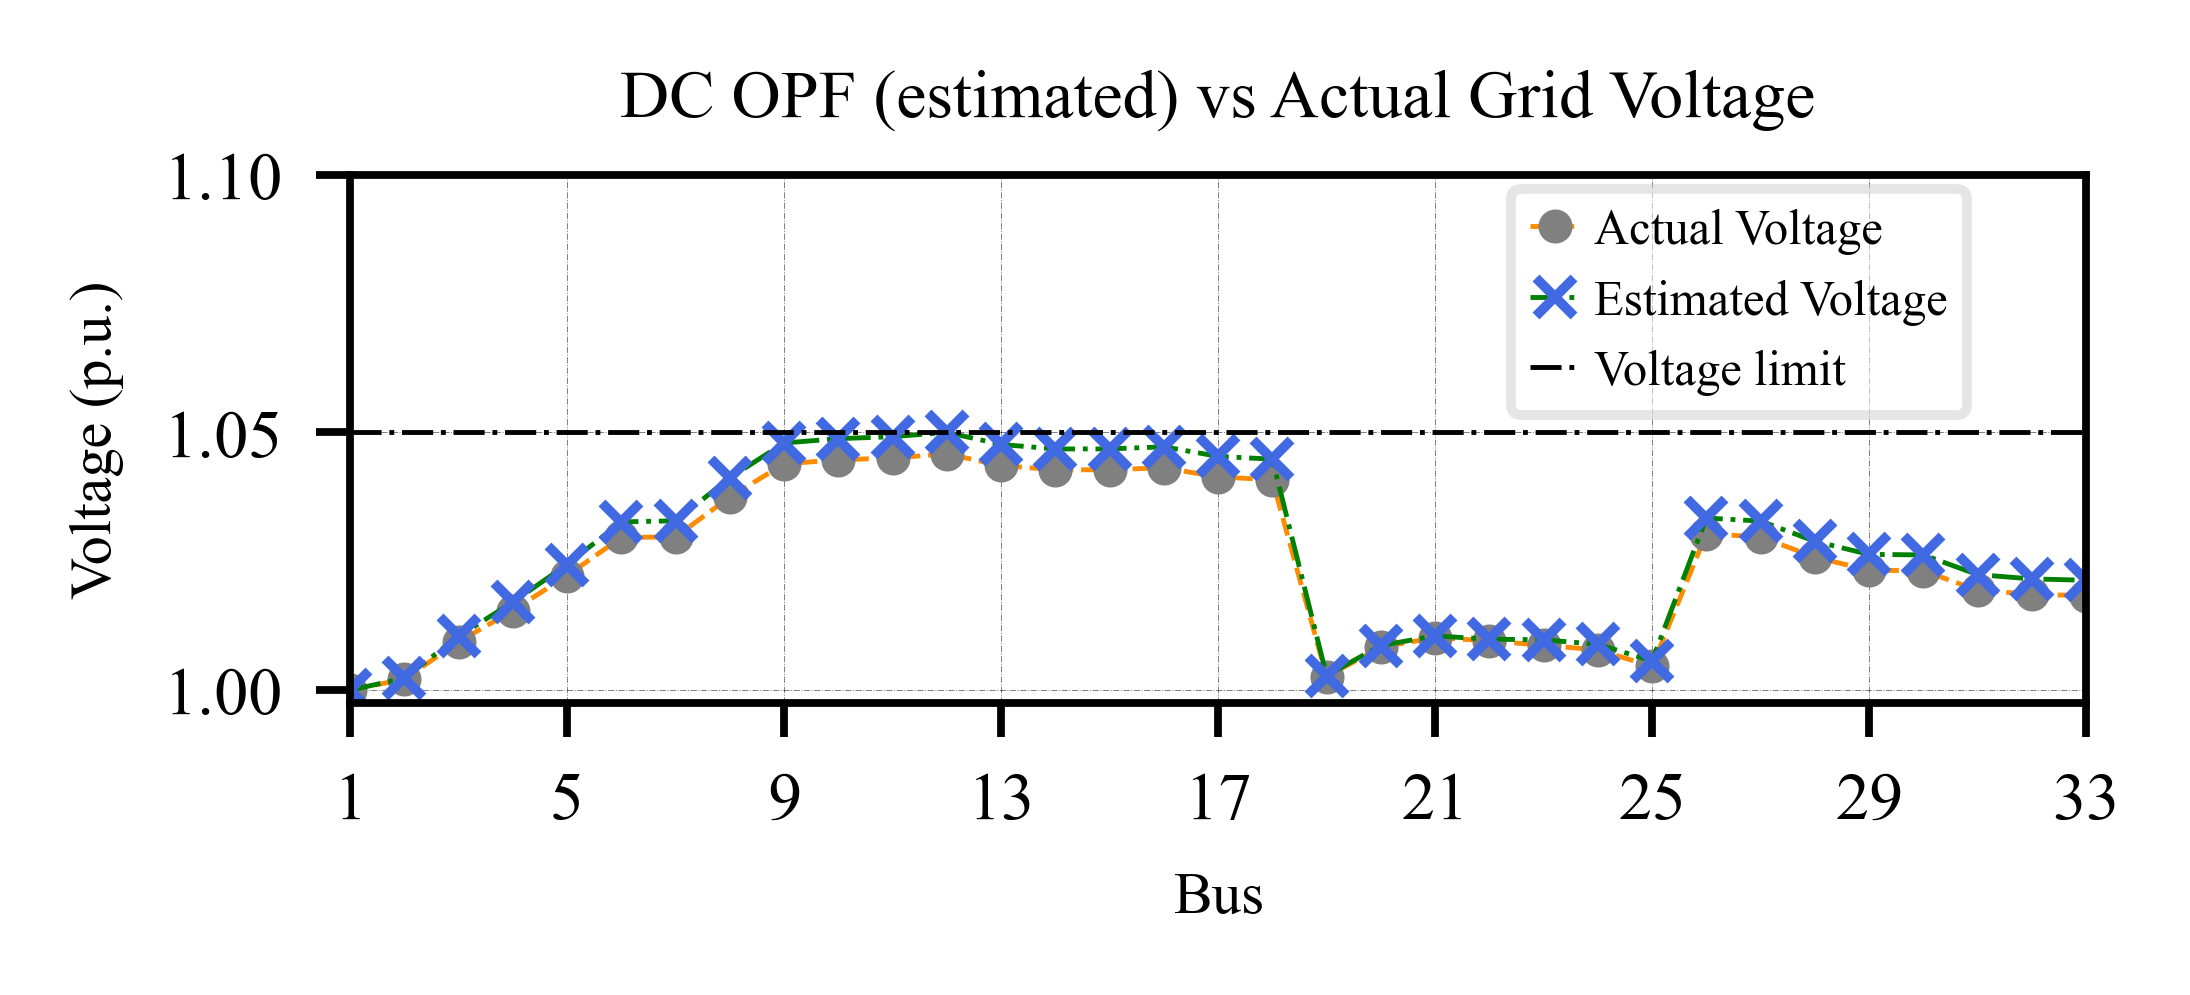

In [25]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700, sharex=True,)
csfont = {'fontname': 'Times New Roman'}

ax.plot(voltage_dc ,linestyle = "--",linewidth = .5, marker = ".", markersize = 5, 
        alpha=1, mec='gray', mfc = "gray", color ="darkorange", label = "Actual Voltage")
ax.plot(bus_data_dc["voltage"] ,linestyle = "-.",linewidth = .5, marker = "x", markersize = 4, 
        alpha=1, mec='royalblue', mfc = "royalblue", color ="green", label = "Estimated Voltage")
ax.plot(voltage_dc.index, [1.05 for _ in voltage_dc.index],
        linestyle = "-.",linewidth = .5, 
        alpha=1, color ="k", label = "Voltage limit")

    
ax.set_xticks([idx for idx in voltage_dc.index if idx%4 == 0])
ax.set_xticklabels(np.array([idx for idx in voltage_dc.index if idx%4 == 0])+1)

ax.set_yticks([1, 1.05, 1.1])

ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('Voltage (p.u.)', fontsize=6, **csfont,)
ax.set_xlabel('Bus', fontsize=6, **csfont)
ax.set_title('DC OPF (estimated) vs Actual Grid Voltage', fontsize=7, **csfont)


ax.autoscale(enable=True, axis='x', tight=True)

leg = ax.legend(fancybox=True, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.8, 0.5), 
                ncol = 1, prop={'family': 'Times New Roman', 'size': 5},
               handletextpad=0.3, handlelength=1, columnspacing=0.7,)

We can clearly see the gap of mismatch between the actual and estimated voltage in DC OPF.   

Furthermore, let's compare the PV curtailments between proposed controller and DC OPF:

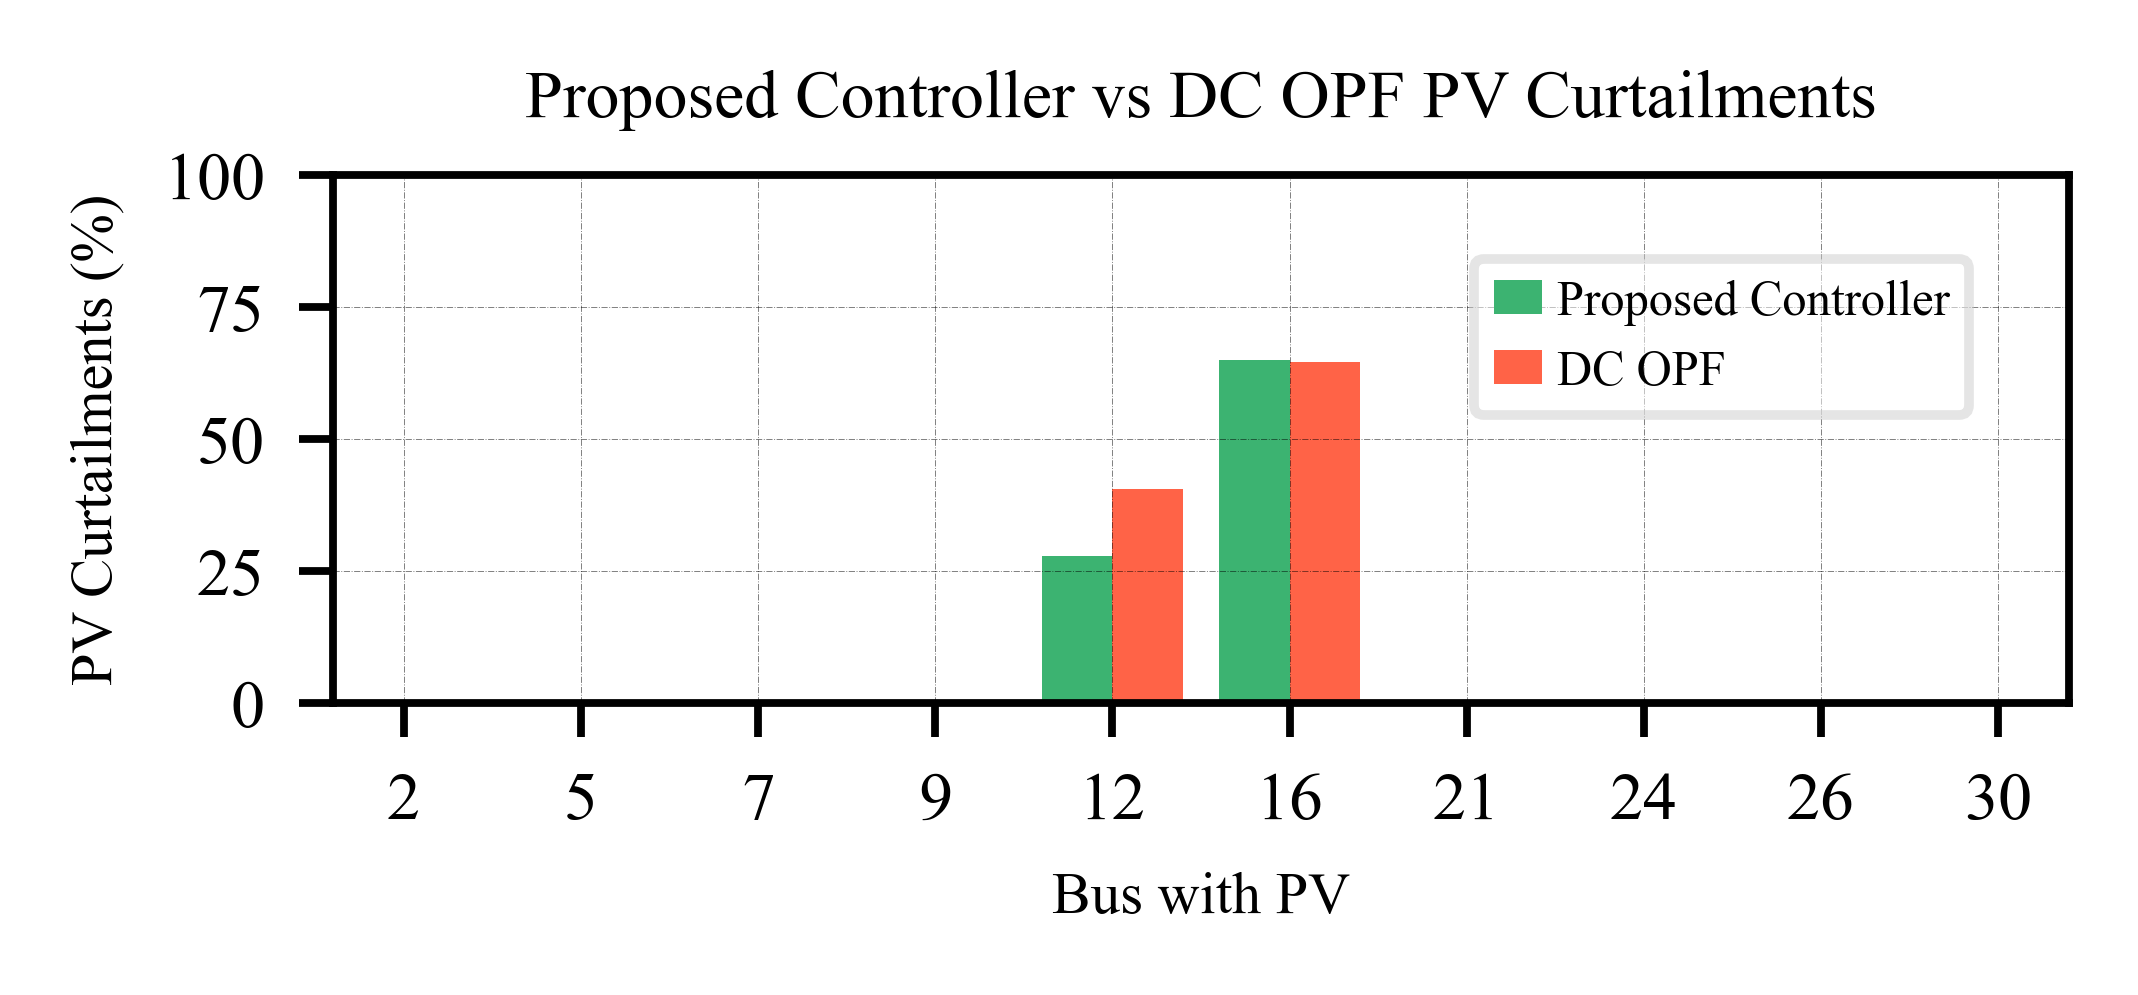

In [26]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 700)
csfont = {'fontname': 'Times New Roman'}

bar_width = 0.4
bus_with_pv = bus_data[bus_data["S_PV"] > 0].index

ax.bar(np.array([pv for pv in range(len(bus_data.index[bus_with_pv]))]), 
       bus_data["curt"].values[bus_with_pv], width = bar_width, 
       color = "mediumseagreen", label = 'Proposed Controller')

ax.bar(np.array([pv for pv in range(len(bus_data.index[bus_with_pv]))]) + bar_width, 
       bus_data_dc["curt"].values[bus_with_pv], width = bar_width, 
       color = "tomato", label = "DC OPF")   

ax.set_xticks(np.array([pv for pv in range(len(bus_data.index[bus_with_pv]))]) + .2)
ax.set_xticklabels(bus_with_pv + 1)

ax.set_yticks(np.arange(0,101, 25))

ax.grid(axis= "y", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)
ax.grid(axis= "x", color = 'k', linestyle = '-.', alpha = 0.5, linewidth = 0.1)

# modify font 
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(7)
    tick.set_rotation(0)
    
ax.set_ylabel('PV Curtailments (%)', fontsize=6, **csfont,)
ax.set_xlabel('Bus with PV', fontsize=6, **csfont)
ax.set_title('Proposed Controller vs DC OPF PV Curtailments', fontsize=7, **csfont)

ax.autoscale(enable=True, axis='x', tight=True)

leg = ax.legend(fancybox=True, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.8, 0.5), 
                ncol = 1, prop={'family': 'Times New Roman', 'size': 5},
               handletextpad=0.3, handlelength=1, columnspacing=0.7,)

We can see in the figure above that the inacuraccy of the DC OPF leads to more PV curtailed in bus 12. In real life, this situation will incur more economic loss for the PV owners and useful renewable resources will be wasted. 

# 3. Sensitivity Analysis <a name="Sensitivity"></a>

The sensitivity analysis aims to observe the performance of the proposed controller based on different configuration of the parameters (**C<sub>loss</sub>** and **C<sub>pv</sub>**). To recall, the objective function of the proposed controller is:

$$\large{\min C_{loss} \underbrace{\sum_{(i,j) \in E} \ell_{ij}r_{ij}}_{\text{losses}} + C_{pv} \underbrace{\sum_{b \in B} P^{pv}_b - P^{pv*}_b}_\text{PV curtailments}}$$

The considered parameters value are between [1, 99]

In [27]:
c_loss_range = np.arange(1, 101, 2)
c_pv_range = np.arange(1, 101, 2)

Run the sensitivity analysis

In [28]:
if __name__ == '__main__':
    feasibility, pv_production, voltage_max = algo.solve.sensitivity(bus_data, branch_data, c_loss_range, c_pv_range)

Save the results, so we don't have to re-run sensitivity analysis:

In [ ]:
feasibility.to_csv("feasibility.csv", index= True)
pv_production.to_csv("pv_production.csv", index= True)
voltage_max.to_csv("voltage_max.csv", index= True)

Open the sensitivity analysis results:

In [ ]:
feasibility = pd.read_csv("feasibility.csv", index_col= 0)
pv_production = pd.read_csv("pv_production.csv", index_col= 0)
voltage_max = pd.read_csv("voltage_max.csv", index_col= 0)

# Edit the column into integer
feasibility.columns = [int(x) for x in feasibility.columns]
pv_production.columns = [int(x) for x in pv_production.columns]
voltage_max.columns = [int(x) for x in voltage_max.columns]

Generate matricies for different controller operating regions

In [29]:
# Region 1: Infeasible region
Infeasible_matrix = np.zeros(feasibility.values.shape)

# Region 2: Losses minimization region (objective function 1)
loss_max_matrix = np.zeros(voltage_max.values.shape)

# Region 3: PV maximization region (objective function 2)
PV_max_matrix = np.zeros(pv_production.values.shape)

for cl, closs in enumerate(c_loss_range):
    for cp, cpv in enumerate(c_pv_range):
        if feasibility.loc[closs, cpv] == True and voltage_max.loc[closs, cpv] >= 1.05 - 0.001:
            PV_max_matrix[cl, cp] = pv_production.loc[closs, cpv]
        elif feasibility.loc[closs, cpv] == True and voltage_max.loc[closs, cpv] < 1.05 - 0.001:
            loss_max_matrix[cl, cp] = pv_production.loc[closs, cpv]
        else:
            Infeasible_matrix[cl, cp] = 1

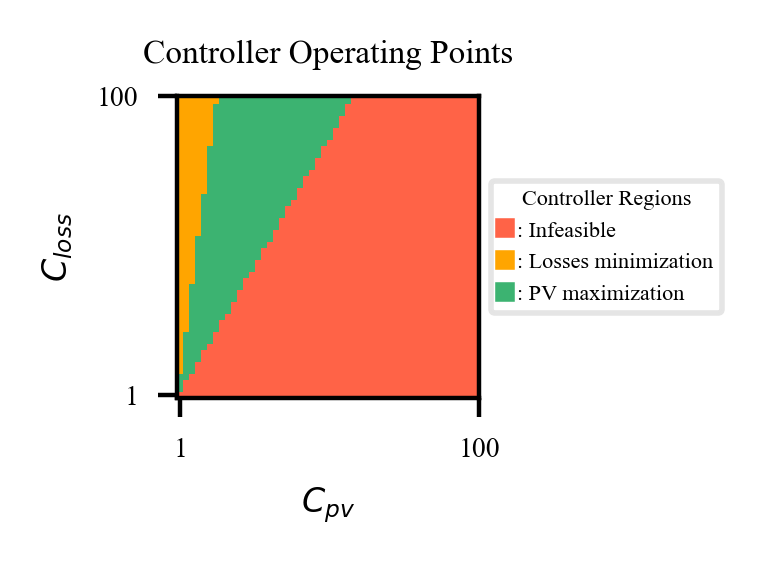

In [30]:
import matplotlib
from matplotlib.lines import Line2D

fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (3.2, 1), dpi = 400)
csfont = {'fontname': 'Times New Roman'}

# Generate custom color map
cmap1 = matplotlib.colors.ListedColormap(['none', 'tomato'])
cmap2 = matplotlib.colors.ListedColormap(['none', 'mediumseagreen'])
cmap3 = matplotlib.colors.ListedColormap(['none', 'orange'])

# Plot different controller regions
ax.imshow(Infeasible_matrix, cmap = cmap1, origin='lower')
ax.imshow(PV_max_matrix, cmap = cmap2, origin='lower')
ax.imshow(loss_max_matrix, cmap = cmap3, origin='lower')

# Set axis
ax.set_yticks([0, 50])
ax.set_yticklabels([1, 100])

ax.set_xticks([0, 50])
ax.set_xticklabels([1, 100])

for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(5)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(5)
    tick.set_rotation(0)
    
ax.set_ylabel('$C_{loss}$', fontsize=6, **csfont,)
ax.set_xlabel('$C_{pv}$', fontsize=6, **csfont)
ax.set_title('Controller Operating Points', fontsize=6, **csfont)
    
# For custom legend
line = [Line2D([0], [0], linestyle = "",
               marker = "s", markersize=2.5, color='tomato', markeredgewidth=1),
        Line2D([0], [0], linestyle = "",
               marker = "s", markersize=2.5, color='orange', markeredgewidth=1),
        Line2D([0], [0], linestyle = "",
               marker = "s", markersize=2.5, color='mediumseagreen', markeredgewidth=1),]

leg = ax.legend(handles=line, labels=[": Infeasible", ": Losses minimization", ": PV maximization"],
        ncol=1 , handletextpad=0.3, handlelength=.5, columnspacing=0.7,
        fancybox=True, framealpha=.5,frameon=True,
       loc='center left', bbox_to_anchor=(1, .5), prop={'family': 'Times New Roman', 'size': 4})
    
leg.set_title('Controller Regions',prop={'family': 'Times New Roman', 'size': 4},)


The sensitivity analysis obtained 3 different controller regions:
1. **Infeasible**: The region where the controller is not feasible/does not work properly due to **inacurracy of the convex relaxation**.
2. **Losses minimization**: The region where the losses minimization is prioritized. The PV production in this case, may be curtailed more in order to minimize the losses.
3. **PV Maximizaton**: The region where PV curtailment is minimized (PV production is maximized)

The more details about the regions are explained in my publication [2]

# 4. Conclusion <a name="Conclusion"></a>

We have seen that the proposed voltage control is effective to maintain the grid voltage. It can help us to optimally find the best PV setpoints, in which the overvoltage can be minimized. 

The accuracy of the proposed voltage control is significantly higher than the conventional DC OPF, which also highlights that the convex relaxation works properly with the pre-selected parameters.

However, the controller's parameters have to be carefully selected to ensure the controller in the good operating region, as highlighted in the sensitivity analysis.
